In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define hyperparameters
EPOCHS = 100
BATCH_SIZE = 128
noise_dim = 100
num_examples_to_generate = 16

# Load the MNIST dataset
(x_train, _), (_, _) = keras.datasets.mnist.load_data()
#train_dataset, validation_dataset, test_dataset = keras.datasets.celeba.load_data()



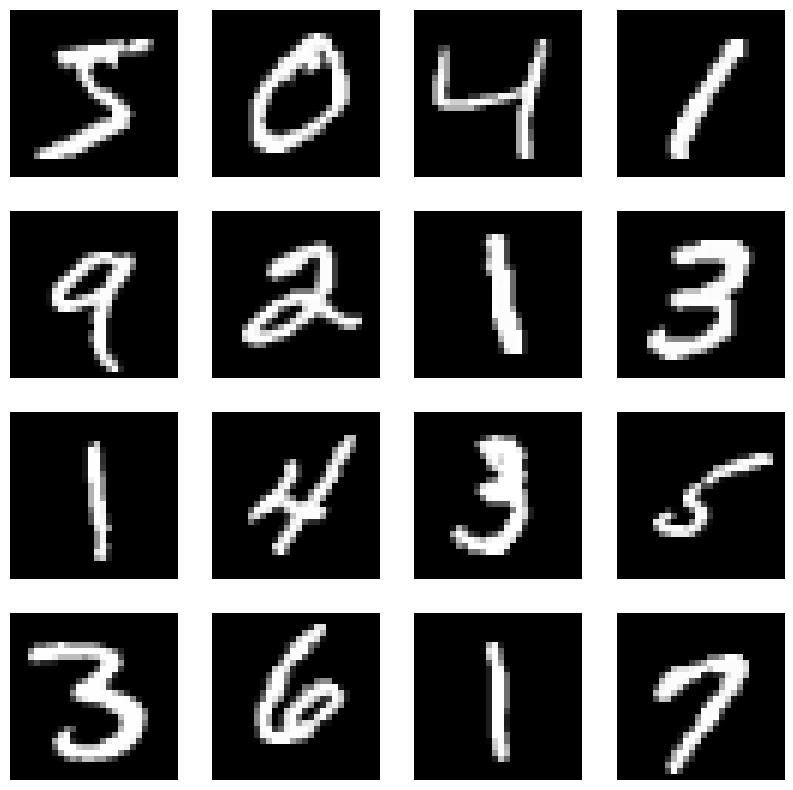

In [14]:
import matplotlib.pyplot as plt

def display_images(images, num_images=16):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
    plt.show()

display_images(x_train)

In [15]:
x_train.shape

(60000, 28, 28)

In [16]:
# Normalize the pixel values to be between -1 and 1
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_train = (x_train - 127.5) / 127.5

# Create a tf.data.Dataset object for the MNIST dataset
dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

The generator model in a GAN transforms random noise into an image-like structure using Dense and Conv2DTranspose layers to expand the dimensions. BatchNormalization is used to stabilize training, and LeakyReLU helps prevent the vanishing gradient problem. The final output is a 28x28 grayscale image with pixel values normalized between -1 and 1.

In [17]:
# Create the generator and discriminator models
def make_generator_model():
    model = keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

The discriminator model in a GAN consists of several convolutional layers that extract features from the image, followed by Leaky ReLU activations and Dropout to improve performance and prevent overfitting. Finally, the data is flattened into a one-dimensional vector and classified with a single dense layer to determine whether the image is real or fake

In [18]:
def make_discriminator_model():
    model = keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [19]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [20]:
# Define the loss functions for the generator and discriminator
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

In [21]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
# Define the optimizers for the generator and discriminator
generator_optimizer = keras.optimizers.Adam(1e-4)
discriminator_optimizer = keras.optimizers.Adam(1e-4)

In [22]:
# Define the training loop
import numpy as np

def train_step(images):
    # Generating noise from a normal distribution
    fake_img_noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(fake_img_noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        print("gen_loss" , np.mean(gen_loss))
        print("disc_loss" , np.mean(disc_loss))
        #print("gen_loss" , gen_loss)

# Train the GAN model
def train(dataset, epochs):
    for epoch in range(epochs):
        for batch in dataset:
            train_step(batch)

# Train the GAN model
train(dataset, EPOCHS)

Streaming output truncated to the last 5000 lines.
gen_loss 0.9992777
disc_loss 1.0359242
gen_loss 0.994397
disc_loss 1.0057102
gen_loss 1.0212522
disc_loss 0.9918598
gen_loss 0.98529255
disc_loss 1.009654
gen_loss 1.0087881
disc_loss 1.0502803
gen_loss 0.96476465
disc_loss 1.1018307
gen_loss 0.9947907
disc_loss 1.0906477
gen_loss 0.945533
disc_loss 1.1356349
gen_loss 0.92821413
disc_loss 1.1117451
gen_loss 0.8876215
disc_loss 1.2127424
gen_loss 0.8421272
disc_loss 1.1924809
gen_loss 0.83723444
disc_loss 1.2073877
gen_loss 0.8434788
disc_loss 1.2555523
gen_loss 0.8316909
disc_loss 1.3185719
gen_loss 0.82038283
disc_loss 1.3128004
gen_loss 0.7869683
disc_loss 1.3622268
gen_loss 0.7522274
disc_loss 1.4453089
gen_loss 0.7156291
disc_loss 1.4325997
gen_loss 0.7073718
disc_loss 1.416338
gen_loss 0.70066106
disc_loss 1.5310438
gen_loss 0.6441353
disc_loss 1.5496652
gen_loss 0.70728
disc_loss 1.4085991
gen_loss 0.71143407
disc_loss 1.4595459
gen_loss 0.6776944
disc_loss 1.4349176
gen_loss 0.7

KeyboardInterrupt: 

In [ ]:
plt.imshow(generator(np.random.randn(1,100)).reshape(28,28),cmap='gray')


In [ ]:
# Save the generator weights to a file
generator.save_weights('generator_weights.h5')

# Load the generator weights from the file
generator.load_weights('generator_weights.h5')

# Generate some fake images using the trained generator
noise = tf.random.normal([num_examples_to_generate, noise_dim])
generated_images = generator(noise, training=False)

# Plot the generated images
fig = plt.figure(figsize=(4,4))
for i in range(generated_images.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow((generated_images[i]*0.5 + 0.5).numpy())
    plt.axis('off')
plt.show()